In [98]:
from glob import glob
import os, sys
from functools import partial
import json

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import pymannkendall
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import utils
import warnings
warnings.filterwarnings('ignore')
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe

import drift_functions
import sn_plotting

from importlib import reload
from typing import List, Any, Callable, Union, Tuple, Optional
from numpy.typing import ArrayLike
from matplotlib.axes import Axes

In [2]:
notebook_number = 'draft_06_zec'

In [3]:
os.listdir(constants.ZECMIP_LOCAL_REGRIDDED_DIR)

['esm-piControl',
 '1pct',
 'old',
 'A1',
 'landsea_mask.nc',
 'signal_to_noise',
 '.ipynb_checkpoints',
 'picontrol']

In [4]:
# File that contains all the saved paths for zecmip runs
with open(os.path.join(os.getcwd(), 'Documents', 'PhD', 'data', 'zecmip_experiment_paths.json'), 'r') as f:
    zecmip_model_paths = json.loads(f.read())

In [5]:
# For some reason some of the esm-piControl models don't open as easily.
esm_picontrol_ds_raw_list = []
for key, obj in zecmip_model_paths.items():
    print(f'{key} - ' + obj['esm-piControl'], end='')
    if isinstance(obj['esm-piControl'], str):
        name = key.split('_')[0] # Model name is the first part of the key (e.g. CanESM5_r1i1p2f1_Amon)
        try: # Try with cftime
            open_func = partial(xr.open_mfdataset,  use_cftime=True, engine='h5netcdf')
            ds = open_ds.open_and_rename(os.path.join(obj['esm-piControl'], '*.nc'), open_func, name)
            esm_picontrol_ds_raw_list.append(ds)
            print(' - default open')
        except OSError: # Sometimes above fails (nto sure why)
            print(' - OSError (trying with no kwargs)')
            open_func = xr.open_mfdataset
            ds = open_ds.open_and_rename(os.path.join(obj['esm-piControl'], '*.nc'), open_func, name)
            esm_picontrol_ds_raw_list.append(ds)
            
esm_picontrol_ds_raw_list = [ds-273.15 for ds in esm_picontrol_ds_raw_list]

CanESM5_r1i1p2f1_Amon - /g/data/w40/ab2313/PhD/zecmip/original/esm_picontrol/CanESM5CanESM5 (/g/data/w40/ab2313/PhD/zecmip/original/esm_picontrol/CanESM5/*.nc)
 - default open
MIROC-ES2L_r1i1p1f2_Amon - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/esm-piControl/r1i1p1f2/Amon/tas/gn/v20200428MIROC-ES2L (/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/esm-piControl/r1i1p1f2/Amon/tas/gn/v20200428/*.nc)
 - default open
UKESM1-0-LL_r1i1p1f2_Amon - /g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/esm-piControl/r1i1p1f2/Amon/tas/gn/v20190916UKESM1-0-LL (/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/esm-piControl/r1i1p1f2/Amon/tas/gn/v20190916/*.nc)
 - default open
MPI-ESM1-2-LR_r1i1p1f1_Amon - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190815MPI-ESM1-2-LR (/g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190815/*.nc)
 - default open
GISS-E2-1-G-CC_r1i1p1f1_Amon - /g/data/w40/ab2313/PhD/zecmip

In [6]:
pct_ds_raw_list = [open_ds.open_and_rename(os.path.join(obj['1pct'], '*.nc'),  partial(xr.open_mfdataset, use_cftime=True))
                          for obj in zecmip_model_paths.values()]
pct_ds_raw_list = [ds-273.15 for ds in pct_ds_raw_list]

CanESM5 (/g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/r1i1p2f1/Amon/tas/gn/v20190429/*.nc)
MIROC-ES2L (/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/1pctCO2/r1i1p1f2/Amon/tas/gn/v20190823/*.nc)
UKESM1-0-LL (/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/1pctCO2/r1i1p1f2/Amon/tas/gn/v20190406/*.nc)
MPI-ESM1-2-LR (/g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/1pctCO2/r1i1p1f1/Amon/tas/gn/v20190710/*.nc)
GISS-E2-1-G (/g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/1pctCO2/r1i1p1f1/Amon/tas/gn/v20180905/*.nc)
CESM2 (/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p1f1/Amon/tas/gn/v20190425/*.nc)
NorESM2-LM (/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-LM/1pctCO2/r1i1p1f1/Amon/tas/gn/v20190815/*.nc)
GFDL-ESM4 (/g/data/oi10/replicas/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/1pctCO2/r1i1p1f1/Amon/tas/gr1/v20180701/*.nc)
ACCESS-ESM1-5 (/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/1pctCO2/r1i1p1f1/Amon/tas/gn/v20191115/*.nc)


In [7]:
# Opening all the needed experiments with the open_and_raname function. This function
# takes an function as an arguement on how to open the dataset. For this a xr.open_mfdataset
# with use_cftime=True filled.
a1_ds_raw_list = [open_ds.open_and_rename(os.path.join(obj['1000pgc'], '*.nc'),  partial(xr.open_mfdataset, use_cftime=True))
                          for obj in zecmip_model_paths.values()]
a1_ds_raw_list = [ds-273.15 for ds in a1_ds_raw_list]

CanESM5 (/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429/*.nc)
MIROC-ES2L (/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622/*.nc)
UKESM1-0-LL (/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210/*.nc)
MPI-ESM1-2-LR (/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20190815/*.nc)
GISS-E2-1-G-CC (/g/data/oi10/replicas/CMIP6/C4MIP/NASA-GISS/GISS-E2-1-G-CC/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191202/*.nc)
CESM2 (/g/data/oi10/replicas/CMIP6/C4MIP/NCAR/CESM2/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191119/*.nc)
NorESM2-LM (/g/data/oi10/replicas/CMIP6/C4MIP/NCC/NorESM2-LM/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191108/*.nc)
GFDL-ESM4 (/g/data/oi10/replicas/CMIP6/C4MIP/NOAA-GFDL/GFDL-ESM4/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gr1/v20180701/*.nc)
ACCESS-ESM1-5 (/g/dat

# Calculating Global Average

In [8]:
def standardise_data_and_timestamp(da: Union[xr.Dataset, xr.DataArray]) -> Union[xr.Dataset, xr.DataArray]:
    # Make sure dims have correct names
    da = da.drop(['bnds', 'height', 'bounds', 'lev', 'level'], errors='ignore')
    # Resample data to yearly frequency
    da = da.resample(time='Y').mean()
    da['time'] = open_ds.make_new_time(da, freq='1Y')
    
    return da

In [9]:
def standardise_data_and_calculate_global_value(da_list:List[Union[xr.DataArray, xr.Dataset]], variable:str) -> xr.DataArray:
    '''
    Standardizes the input data and calculates the global mean value.
    
    Args:
        da_list (List[Union[xr.DataArray, xr.Dataset]]): List of xarray DataArrays or Datasets.
        variable (str): Name of the variable to extract from Datasets, if provided.
    
    Returns:
        xr.DataArray: Merged xarray DataArray containing standardized and calculated global mean values.
    '''
    to_merge = []
    for da in da_list:
        print(da.model.values[0])
        da_copy = da.copy(deep=True) # Create a deep copy of the input to avoid modifying the original data
        if isinstance(da, xr.Dataset):
            da = da[variable]
        # Make sure dims have correct names
        da = da.drop(['bnds', 'height', 'bounds', 'lev', 'level'], errors='ignore')
        # Resample data to yearly frequency
        da = da.resample(time='Y').mean()
        da['time'] = open_ds.make_new_time(da, freq='1Y')
        da = sn.calculate_global_value(da, variable).compute()
        to_merge.append(da.drop('height', errors='ignore'))
        
    return  xr.merge(to_merge)

In [10]:
esm_picontrol_smean_ds = standardise_data_and_calculate_global_value(esm_picontrol_ds_raw_list, 'tas')

CanESM5
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 1000
(None, None)
MIROC-ES2L
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 500
(None, None)
UKESM1-0-LL
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 250
(None, None)
MPI-ESM1-2-LR
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 500
(None, None)
GISS-E2-1-G-CC
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 170
(None, None)
CESM2
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 500
(None, None)
NorESM2-LM
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 250
(None, None)
GFDL-ESM4
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 500
(None, None)
ACCESS-ESM1-5
Chaning time to range between 0001-12-31 00:00:00 and 0002

In [11]:
pct_ds_smean_ds = standardise_data_and_calculate_global_value(pct_ds_raw_list, 'tas')
pct_ds_smean_ds = open_ds.reformat_giss_key_for_onepct(pct_ds_smean_ds)

CanESM5
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 151
(None, None)
MIROC-ES2L
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 150
(None, None)
UKESM1-0-LL
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 150
(None, None)
MPI-ESM1-2-LR
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 165
(None, None)
GISS-E2-1-G
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 151
(None, None)
CESM2
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 150
(None, None)
NorESM2-LM
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 150
(None, None)
GFDL-ESM4
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 150
(None, None)
ACCESS-ESM1-5
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-

In [12]:
a1_ds_smean_ds = standardise_data_and_calculate_global_value(a1_ds_raw_list, 'tas')

CanESM5
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 100
(None, None)
MIROC-ES2L
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 248
(None, None)
UKESM1-0-LL
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 330
(None, None)
MPI-ESM1-2-LR
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 185
(None, None)
GISS-E2-1-G-CC
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 180
(None, None)
CESM2
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 150
(None, None)
NorESM2-LM
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 100
(None, None)
GFDL-ESM4
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 200
(None, None)
ACCESS-ESM1-5
Chaning time to range between 0001-12-31 00:00:00 and 0002-

In [13]:
esm_picontrol_smean_ds = esm_picontrol_smean_ds - 273.15
pct_ds_smean_ds = pct_ds_smean_ds - 273.15
a1_ds_smean_ds = a1_ds_smean_ds - 273.15

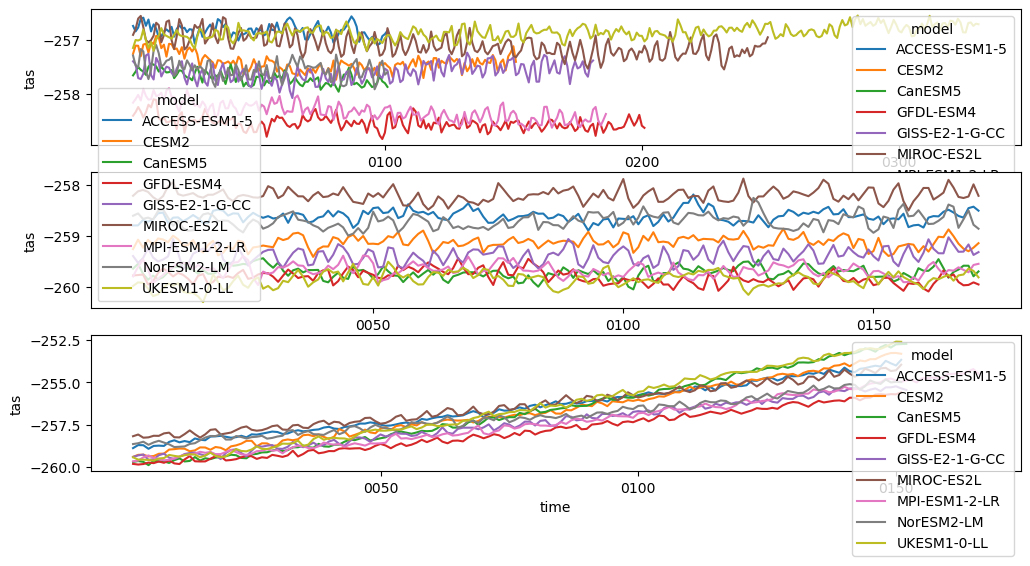

In [14]:
fig, axes = plt.subplots(3, figsize=(12, 6))
a1_ds_smean_ds.tas.plot(hue='model', ax=axes[0]);
esm_picontrol_smean_ds.dropna(dim='time').tas.plot(hue='model', ax=axes[1]);
pct_ds_smean_ds.tas.plot(hue='model', ax=axes[2]);

In [15]:
reload(sn)

<module 'signal_to_noise' from '/home/563/ab2313/Documents/PhD/modules/signal_to_noise.py'>

In [16]:
# Calculate the man at the br"anch point of this data set 
branch_point_mean_ds = sn.calculate_branch_point_values(pct_ds_smean_ds)

# Calculate the ZEC anomalies
a1_ds_smean_zec25_ds = a1_ds_smean_ds.isel(time=slice(19, 30)).mean(dim='time') - branch_point_mean_ds

In [17]:
a1_ds_smean_zec25_ds.to_pandas()

tas
model                   
ACCESS-ESM1-5   0.067768
CESM2          -0.039028
CanESM5         0.098098
GFDL-ESM4      -0.047400
GISS-E2-1-G-CC  0.023554
MIROC-ES2L     -0.026773
MPI-ESM1-2-LR  -0.125772
NorESM2-LM     -0.208566
UKESM1-0-LL     0.313260

In [18]:
a1_ds_smean_zec25_ds.to_pandas()

tas
model                   
ACCESS-ESM1-5   0.067768
CESM2          -0.039028
CanESM5         0.098098
GFDL-ESM4      -0.047400
GISS-E2-1-G-CC  0.023554
MIROC-ES2L     -0.026773
MPI-ESM1-2-LR  -0.125772
NorESM2-LM     -0.208566
UKESM1-0-LL     0.313260

In [19]:
a1_ds_smean_zec25_ds.to_pandas()

tas
model                   
ACCESS-ESM1-5   0.067768
CESM2          -0.039028
CanESM5         0.098098
GFDL-ESM4      -0.047400
GISS-E2-1-G-CC  0.023554
MIROC-ES2L     -0.026773
MPI-ESM1-2-LR  -0.125772
NorESM2-LM     -0.208566
UKESM1-0-LL     0.313260

# ZEC anomly period analysis

## Global Values

In [20]:
zec_manual_df = a1_ds_smean_zec25_ds.to_pandas().copy(deep=True)
zec_manual_df = zec_manual_df.rename(columns={'tas':'ZEC25'})
zec_manual_df['ZEC25'] = [0.04, -0.04, -0.11, 0.11, -0.18, -0.02, -0.22, -0.27, .21]
zec_manual_df['ZEC50'] = [0.01, -0.13, -0.31, 0.06, -0.27, -0.08, -0.27, -0.33, 0.28]
zec_manual_df

ZEC25  ZEC50
model                       
ACCESS-ESM1-5    0.04   0.01
CESM2           -0.04  -0.13
CanESM5         -0.11  -0.31
GFDL-ESM4        0.11   0.06
GISS-E2-1-G-CC  -0.18  -0.27
MIROC-ES2L      -0.02  -0.08
MPI-ESM1-2-LR   -0.22  -0.27
NorESM2-LM      -0.27  -0.33
UKESM1-0-LL      0.21   0.28

In [21]:
esm_picontrol_smean_ds = esm_picontrol_smean_ds.dropna(dim='time')

In [22]:
def calculate_rolling_period_diff(da: xr.DataArray, period:int) -> xr.DataArray:
    """
    Calculate the rolling period difference between two slices of a given DataArray.
    Parameters:
        da (xr.DataArray): Input DataArray.
    Returns:
        xr.DataArray: Rolling period difference.
    """
    # Get the length of the time dimension
    time_length = len(da.time.values)

    # Slice from the start until the final 25 time steps
    slice1 = da.isel(time=slice(None, time_length - period))
    # Slice from year 25 until the end
    slice2 = da.isel(time=slice(period, None))

    # Calculate the rolling mean with a window size of 20 and drop NA values
    slice1_rolling = slice1.rolling(time=20).mean(dim='time').dropna(dim='time')
    slice2_rolling = slice2.rolling(time=20).mean(dim='time').dropna(dim='time')

    # Calculate the difference between the two rolling means
    diff_np = slice2_rolling.values - slice1_rolling.values

    # Create a new DataArray with the same dimensions as the sliced data
    diff_da = xr.zeros_like(da.isel(time=slice(None, len(slice1_rolling.time.values))))
    diff_da += diff_np

    return diff_da

In [23]:
esm_pi_control_zec25 = calculate_rolling_period_diff(esm_picontrol_smean_ds.tas, 5)
esm_pi_control_zec50 = calculate_rolling_period_diff(esm_picontrol_smean_ds.tas, 30)

esm_pi_control_zec25

<xarray.DataArray 'tas' (model: 9, time: 146)>
array([[ 0.03180427,  0.01759025,  0.00093535, ...,  0.01880986,
         0.02439322,  0.02553874],
       [-0.01203827, -0.02001274, -0.0249413 , ...,  0.00710747,
         0.00470194, -0.01217506],
       [ 0.04051056,  0.05726633,  0.07694804, ...,  0.00233403,
         0.00978235,  0.01580745],
       ...,
       [ 0.03579124,  0.01635443,  0.01500394, ..., -0.0033625 ,
         0.00312118,  0.01708658],
       [-0.04363612, -0.04584366, -0.04931585, ...,  0.00833594,
         0.00482613, -0.00498101],
       [ 0.02565564,  0.03760254,  0.03052632, ...,  0.03868355,
         0.03726073,  0.0437692 ]])
Coordinates:
  * model    (model) <U14 'ACCESS-ESM1-5' 'CESM2' ... 'NorESM2-LM' 'UKESM1-0-LL'
  * time     (time) object 0001-12-31 00:00:00 ... 0146-12-31 00:00:00

In [99]:
bound = 0.32; step=0.02
bins = np.arange(-bound, bound+step, step)

In [134]:
def plot_histogram(da: xr.DataArray, zec_df: pd.DataFrame, bins: Union[List[float], np.ndarray],
                   step: int, bar_label: str='', line_label:str='', bar_color: str = 'blue', line_color: str = 'red',
                   fig: Optional[plt.Figure] = None, axes: Optional[List[plt.Axes]] = None,
                   add_legend: bool = False) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Plot histograms for the given DataArray and models.

    Parameters:
        da (xr.DataArray): The input DataArray containing the data to plot.
        zec_df (pd.DataFrame): DataFrame containing ZEC50 values for each model.
        bins (ArrayLike): The bins to use for histogram bins.
        step (int): The width of the bars for each histogram bin.
        label (str): The label to use for the legend.
        bar_color (str): The color of the histogram bars.
        line_color (str): The color of the vertical line indicating ZEC50 value.
        fig (Optional[plt.Figure]): The Figure object to use for plotting.
        axes (Optional[List[plt.Axes]]): The list of Axes objects to use for subplots.
        add_legend (bool): Whether to add a legend to the plot.

    Returns:
        Tuple[plt.Figure, List[plt.Axes]]: The Figure and list of Axes objects used for plotting.
    """
    # Extract model values from the DataArray
    models = da.model.values

    # Create a new figure for plotting
    if fig is None and axes is None:
        fig = plt.figure(figsize=(15, 8))

        # Determine the number of rows and columns for subplot arrangement
        ncols = 3
        nrows = int(np.ceil(len(models) / ncols))
        gs = gridspec.GridSpec(nrows, ncols, hspace=0.45)

        # Create subplots
        axes = [fig.add_subplot(gs[i]) for i in range(nrows * ncols)]

    for num, (ax, model) in enumerate(zip(axes, models)):
        # Select data for the current model and remove NaN values
        vals = da.sel(model=model).dropna(dim='time')

        # Compute histogram and normalize to obtain the density
        hist, edges = np.histogram(vals.values, bins=bins, density=True)
        nsum = len(vals.time.values)

        # Plot the histogram
        ax.bar(edges[:-1], hist / nsum, alpha=0.5, width=step, label=bar_label, color=bar_color)

        # Add a vertical line indicating ZEC50 value for the model
        zec_single_model = zec_df.loc[model]
        ax.axvline(zec_single_model, 0, 1, color=line_color, label=line_label)

        # Set title, limits, and labels for the current subplot
        ax.set_title(f'{model}')
        ax.set_ylim(0, 0.25)
        ax.set_xlabel(r'Temperature Anomaly ($^\circ C$)')
        ax.set_ylabel('Frequency')

        # Add legend only to the first subplot (num=0)
        if not num and add_legend: ax.legend(loc='upper left')

    return fig, axes


In [135]:
repated_kwargs = dict(bins=bins, step=step, add_legend=False)

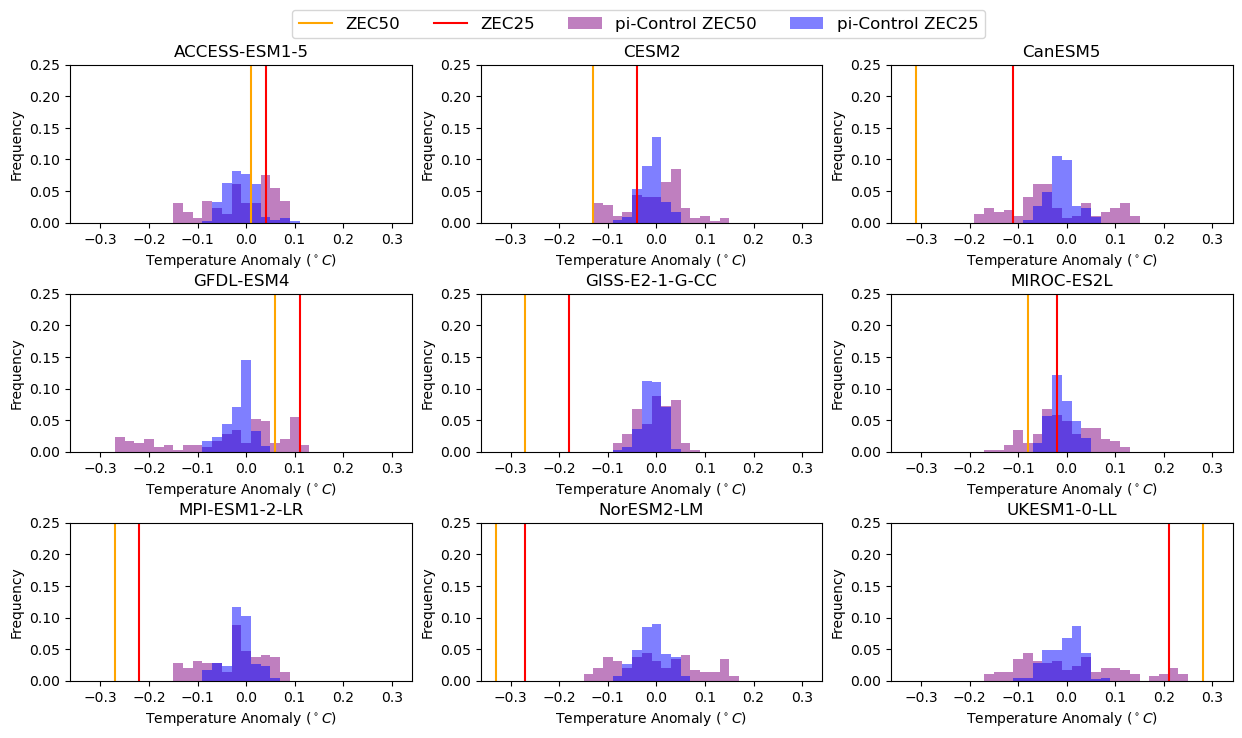

In [152]:
fig, axes = plot_histogram(esm_pi_control_zec50, zec_manual_df.ZEC50, line_label='ZEC50', bar_label='pi-Control ZEC50',
                           bar_color='purple', line_color='orange', **repated_kwargs)
fig, axes = plot_histogram(esm_pi_control_zec25, zec_manual_df.ZEC25, line_label='ZEC25', bar_label='pi-Control ZEC25',
                           fig=fig, axes=axes, **repated_kwargs)

leg = axes[1].legend(ncol=4, bbox_to_anchor=[1.5, 1.4], fontsize=12)

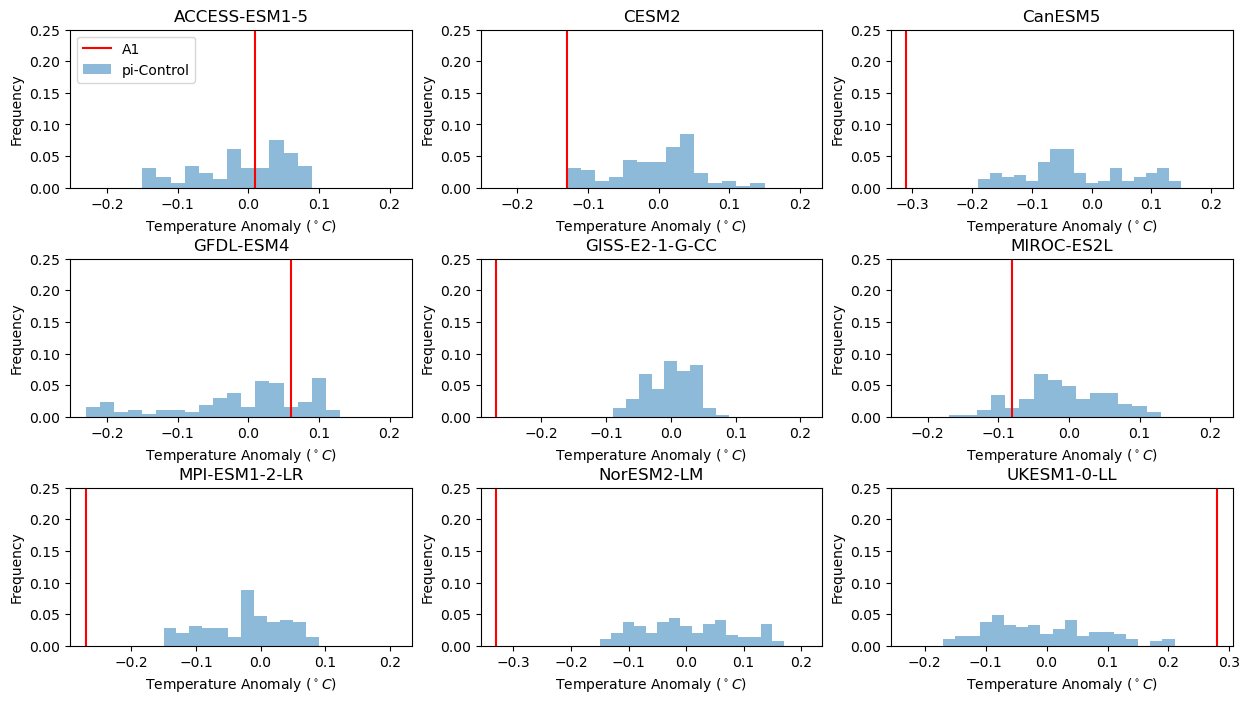

In [25]:
models = esm_pi_control_zec50.model.values
fig = plt.figure(figsize=(15, 8))
ncols = 3
nrows = int(np.ceil(len(models)/ncols))
gs = gridspec.GridSpec(nrows, ncols, hspace=.45)

axes = [fig.add_subplot(gs[i]) for i in range(nrows* ncols)] 
for num, (ax, model) in enumerate(zip(axes, models)):
    vals = esm_pi_control_zec50.sel(model=model).dropna(dim='time')
    #n, bins, patches = ax.hist(vals.values, bins=bins, alpha=.5, label='pi-Control') #  density=True, stacked=True
    hist, edges = np.histogram(vals.values, bins=bins, density=True)
    nsum = len(vals.time.values)#$np.sum(hist)
    ax.bar(edges[:-1], hist/nsum, alpha=.5, width=step, label='pi-Control')
    # zec_single_model = zec_da.sel(model=model).values
    zec_single_model = zec_manual_df.loc[model].ZEC50
    ax.axvline(zec_single_model, 0, 1, color='red', label=r'A1')
    ax.set_title(f'{model}')#(n={int(nsum)})')
    ax.set_ylim(0, .25)
    ax.set_xlabel(r'Temperature Anomaly ($^\circ C$)'); ax.set_ylabel('Frequency')
    if not num: ax.legend(loc='upper left')

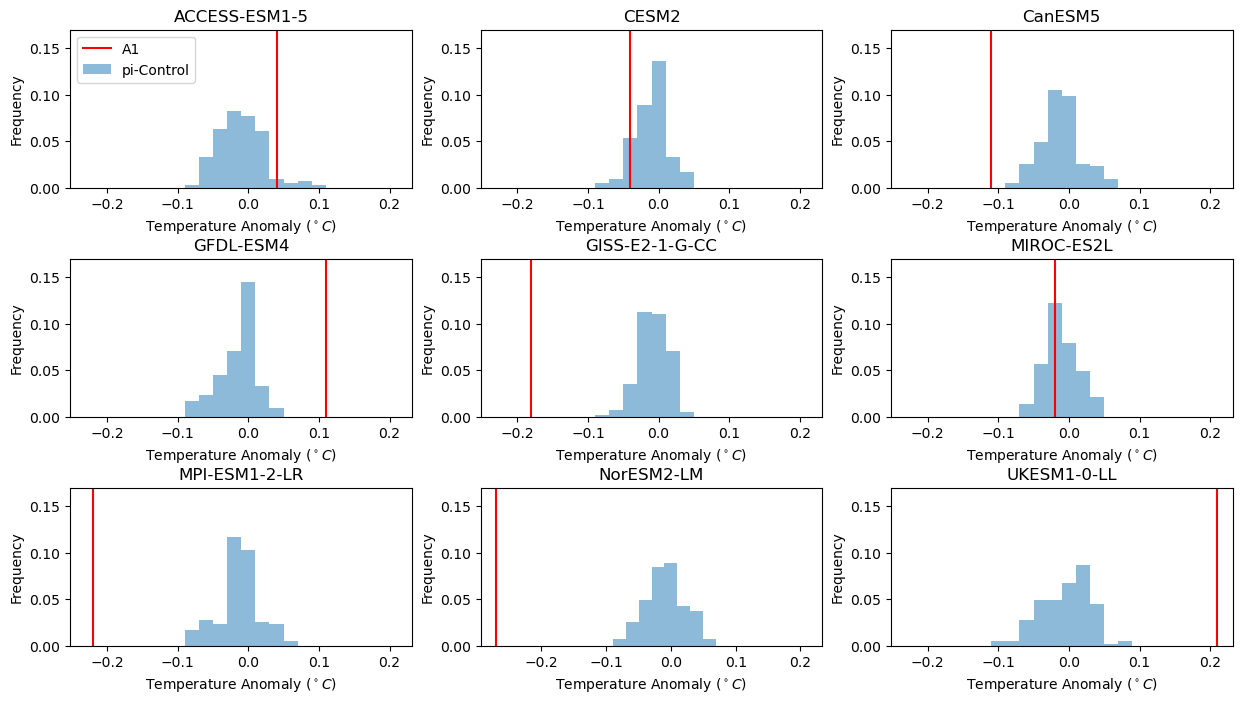

In [26]:
models = esm_pi_control_zec25.model.values
fig = plt.figure(figsize=(15, 8))
ncols = 3
nrows = int(np.ceil(len(models)/ncols))
gs = gridspec.GridSpec(nrows, ncols, hspace=.45)

axes = [fig.add_subplot(gs[i]) for i in range(nrows* ncols)] 
for num, (ax, model) in enumerate(zip(axes, models)):
    vals = esm_pi_control_zec25.sel(model=model).dropna(dim='time')
    #n, bins, patches = ax.hist(vals.values, bins=bins, alpha=.5, label='pi-Control') #  density=True, stacked=True
    hist, edges = np.histogram(vals.values, bins=bins, density=True)
    nsum = len(vals.time.values)#$np.sum(hist)
    ax.bar(edges[:-1], hist/nsum, alpha=.5, width=step, label='pi-Control')
    # zec_single_model = zec_da.sel(model=model).values
    zec_single_model = zec_manual_df.loc[model].ZEC25
    ax.axvline(zec_single_model, 0, 1, color='red', label=r'A1')
    ax.set_title(f'{model}')#(n={int(nsum)})')
    ax.set_ylim(0, .17)
    ax.set_xlabel(r'Temperature Anomaly ($^\circ C$)'); ax.set_ylabel('Frequency')
    if not num: ax.legend(loc='upper left')
# fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 'draft_06_zec_disctribution_comparison.png'), dpi=400, bbox_inches='tight')

## Local Distributions

## Old Class

## List xarray conversion

In [27]:
from listXarray import listXarray

In [28]:
esm_picontrol_ds_xrlist = listXarray(esm_picontrol_ds_raw_list, 'model').to_dataarray('tas').drop(['height'])#.squeeze()
pct_ds_xrlist = listXarray(pct_ds_raw_list, 'model').to_dataarray('tas').drop(['height'])#.squeeze()
a1_ds_xrlist = listXarray(a1_ds_raw_list, 'model').to_dataarray('tas').drop(['height'])#.squeeze()
pct_ds_xrlist

Number of da/ds: 9
---------------
['CanESM5']     ({'model': 1, 'time': 1812, 'lat': 64, 'lon': 128})
['MIROC-ES2L']  ({'model': 1, 'time': 1800, 'lat': 64, 'lon': 128})
['UKESM1-0-LL'] ({'model': 1, 'time': 1800, 'lat': 144, 'lon': 192})
['MPI-ESM1-2-LR']({'model': 1, 'time': 1980, 'lat': 96, 'lon': 192})
['GISS-E2-1-G'] ({'model': 1, 'time': 1812, 'lat': 90, 'lon': 144})
['CESM2']       ({'model': 1, 'time': 1800, 'lat': 192, 'lon': 288})
['NorESM2-LM']  ({'model': 1, 'time': 1800, 'lat': 96, 'lon': 144})
['GFDL-ESM4']   ({'model': 1, 'time': 1800, 'lat': 180, 'lon': 288})
['ACCESS-ESM1-5']({'model': 1, 'time': 1800, 'lat': 145, 'lon': 192})

In [29]:
# !!! This works in-place for some reason (I guess cause they are pointers)
open_ds.reformat_giss_key_for_onepct(pct_ds_xrlist['GISS-E2-1-G']);

In [30]:
# Resample to yearly 
esm_picontrol_ds_xrlist = esm_picontrol_ds_xrlist.resample(time='Y').mean(dim='time').isel(time=slice(None, 170))
pct_ds_xrlist = pct_ds_xrlist.resample(time='Y').mean(dim='time')
a1_ds_xrlist = a1_ds_xrlist.resample(time='Y').mean(dim='time')
a1_ds_xrlist

Number of da/ds: 9
---------------
['CanESM5']     ({'model': 1, 'time': 100, 'lat': 64, 'lon': 128})
['MIROC-ES2L']  ({'model': 1, 'time': 248, 'lat': 64, 'lon': 128})
['UKESM1-0-LL'] ({'model': 1, 'time': 330, 'lat': 144, 'lon': 192})
['MPI-ESM1-2-LR']({'model': 1, 'time': 185, 'lat': 96, 'lon': 192})
['GISS-E2-1-G-CC']({'model': 1, 'time': 180, 'lat': 90, 'lon': 144})
['CESM2']       ({'model': 1, 'time': 150, 'lat': 192, 'lon': 288})
['NorESM2-LM']  ({'model': 1, 'time': 100, 'lat': 96, 'lon': 144})
['GFDL-ESM4']   ({'model': 1, 'time': 200, 'lat': 180, 'lon': 288})
['ACCESS-ESM1-5']({'model': 1, 'time': 101, 'lat': 145, 'lon': 192})

## Above/Below Analysis

In [31]:
# Calculte the anomaly at the branch point
branch_point_local_xrlist = pct_ds_xrlist.apply(sn.calculate_branch_point_values)

In [32]:
# Ref-keys cam be errased - re-set refkeys
branch_point_local_xrlist = branch_point_local_xrlist.set_refkeys('model')
a1_ds_xrlist = a1_ds_xrlist.set_refkeys('model')

In [33]:
a1_ds_local_zec25_xrlist = a1_ds_xrlist.isel(time=slice(19, 30)).mean(dim='time') - branch_point_local_xrlist

In [34]:
esm_zec25_rolling_local_xrlist = esm_picontrol_ds_xrlist.chunk({'time':-1}).apply(calculate_rolling_period_diff, 5)

In [35]:
esm_zec25_rolling_local_xrlist

Number of da/ds: 9
---------------
['CanESM5']     ({'model': 1, 'time': 146, 'lat': 64, 'lon': 128})
['MIROC-ES2L']  ({'model': 1, 'time': 146, 'lat': 64, 'lon': 128})
['UKESM1-0-LL'] ({'model': 1, 'time': 146, 'lat': 144, 'lon': 192})
['MPI-ESM1-2-LR']({'model': 1, 'time': 146, 'lat': 96, 'lon': 192})
['GISS-E2-1-G-CC']({'model': 1, 'time': 146, 'lat': 90, 'lon': 144})
['CESM2']       ({'model': 1, 'time': 146, 'lat': 192, 'lon': 288})
['NorESM2-LM']  ({'model': 1, 'time': 146, 'lat': 96, 'lon': 144})
['GFDL-ESM4']   ({'model': 1, 'time': 146, 'lat': 180, 'lon': 288})
['ACCESS-ESM1-5']({'model': 1, 'time': 146, 'lat': 145, 'lon': 192})

In [36]:
upper_bound_xrlist = esm_zec25_rolling_local_xrlist.apply(xe.percentile, dim='time', q=99).set_refkeys('model')
lower_bound_xrlist = esm_zec25_rolling_local_xrlist.apply(xe.percentile, dim='time', q=1).set_refkeys('model')

In [37]:
warmer_than_pi_xrlist = a1_ds_local_zec25_xrlist.greater_than(upper_bound_xrlist, 1, 0)  

In [38]:
cooler_than_pi_xrlist = a1_ds_local_zec25_xrlist.less_than(lower_bound_xrlist, -1, 0) 

In [39]:
pi_comparison_xrlist = warmer_than_pi_xrlist + cooler_than_pi_xrlist

In [40]:
pi_comparison_xrlist = pi_comparison_xrlist.compute()

In [41]:
models = pi_comparison_xrlist.refkeys
models

array(['CanESM5', 'MIROC-ES2L', 'UKESM1-0-LL', 'MPI-ESM1-2-LR',
       'GISS-E2-1-G-CC', 'CESM2', 'NorESM2-LM', 'GFDL-ESM4',
       'ACCESS-ESM1-5'], dtype='<U14')

In [42]:
import plotting_functions as pf

In [43]:
levels = [-1, 0, 1]

In [44]:
discrete_cmap = pf.create_discrete_cmap('RdBu_r', levels=levels)

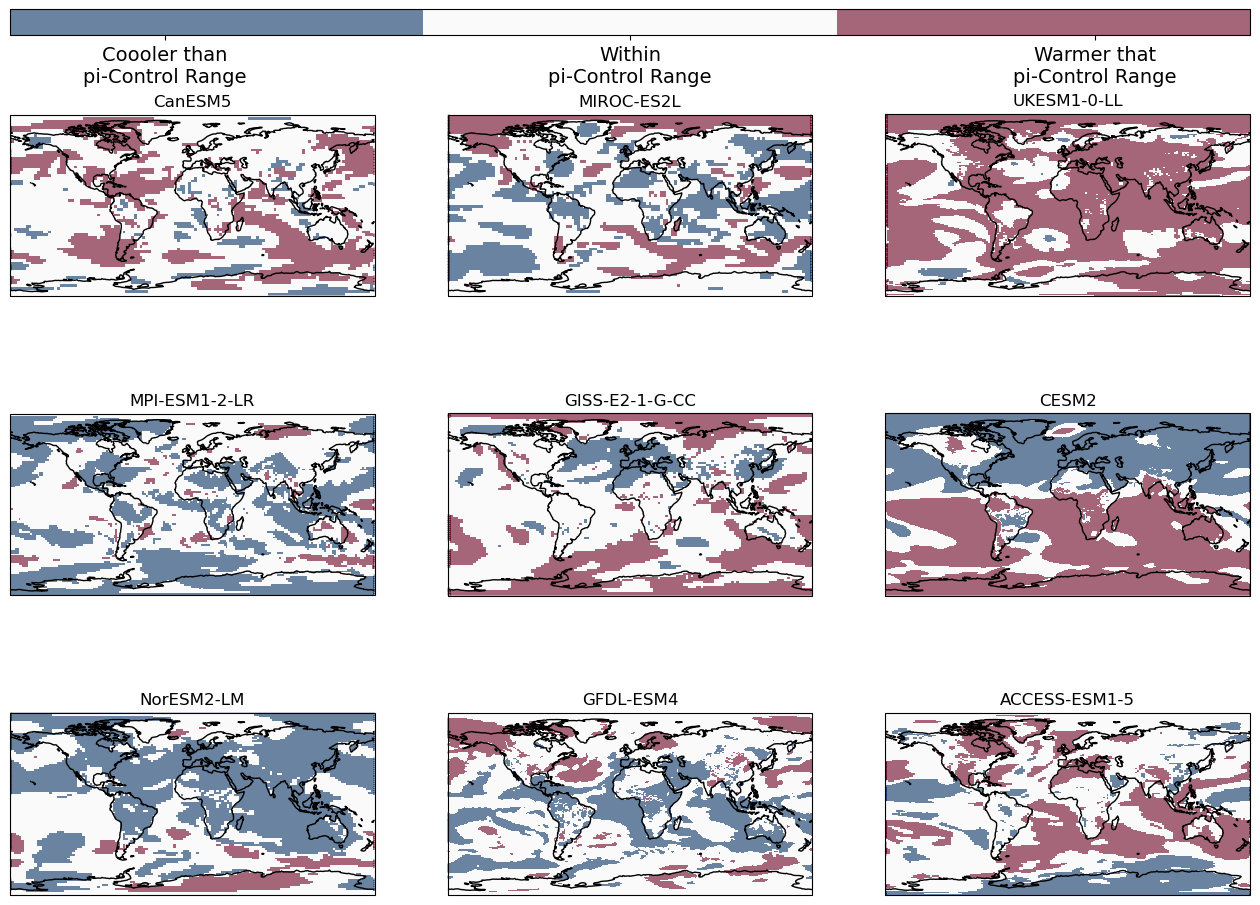

In [45]:
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(4, 3, height_ratios=[0.1] + [1] * 3)
cax = plt.subplot(gs[0, :])
axes = [fig.add_subplot(gs[i+3], projection=ccrs.PlateCarree()) for i in range(9)]

for ax, model in zip(axes, models):
    c = pi_comparison_xrlist[model].plot(ax=ax, vmin=-1, vmax=1, alpha=.6, cmap=discrete_cmap, add_colorbar=False)
    ax.set_title(f'{model}')
    ax.coastlines()
    
cbar = sn_plotting.create_colorbar(c, cax, levels=levels)
cbar.set_ticks([-0.75, 0, 0.75])
cbar.ax.set_xticklabels(['Coooler than\npi-Control Range', 'Within\npi-Control Range', 'Warmer that\npi-Control Range']);

Text(0.5, 1.0, 'Warmer/Cooler the pi')

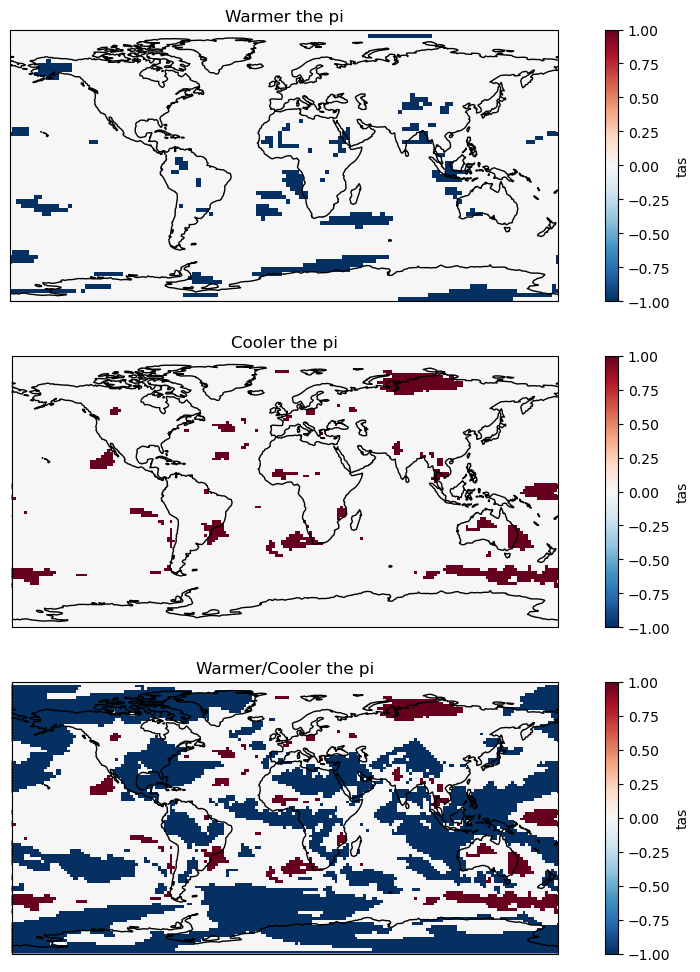

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()
[ax.coastlines() for ax in axes]

kwargs = dict(transform=ccrs.PlateCarree())
cooler_than_pi_xrlist[models].plot(ax=axes[0], vmin=-1, vmax=1, cmap='RdBu_r')
warmer_than_pi_xrlist['MPI-ESM1-2-LR'].plot(ax=axes[1], vmin=-1, vmax=1, cmap='RdBu_r')
pi_comparison_xrlist['MPI-ESM1-2-LR'].plot(ax=axes[2], vmin=-1, vmax=1, cmap='RdBu_r')

axes[0].set_title('Warmer the pi')
axes[1].set_title('Cooler the pi')
axes[2].set_title('Warmer/Cooler the pi')

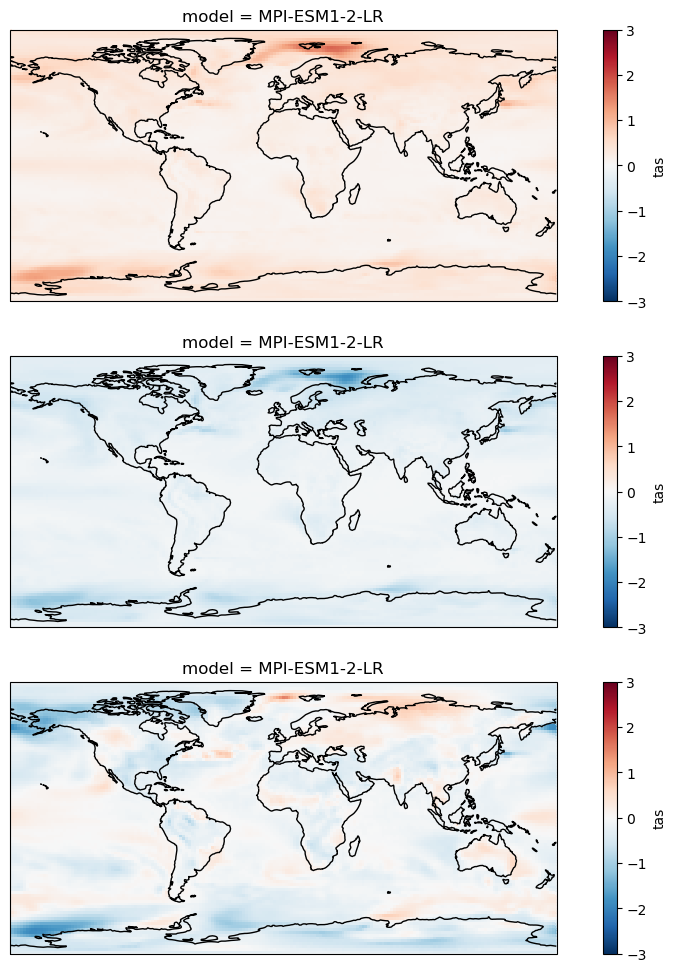

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
[ax.coastlines() for ax in axes]

kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-3, vmax=3)
upper_bound_xrlist['MPI-ESM1-2-LR'].plot(ax=axes[0], **kwargs)
lower_bound_xrlist['MPI-ESM1-2-LR'].plot(ax=axes[1], **kwargs)
a1_ds_local_zec25_xrlist['MPI-ESM1-2-LR'].plot(ax=axes[2], **kwargs)

## Single Ds sample

In [48]:
isel = 3

In [49]:
test_esm_ds = esm_picontrol_ds_raw_list[isel].tas.resample(time='Y').mean().compute()
test_pct_ds = pct_ds_raw_list[isel].tas.resample(time='Y').mean().compute()
test_a1_ds = a1_ds_raw_list[isel].tas.resample(time='Y').mean().compute()

In [50]:
# Calculate the man at the branch point of this data set 
branch_point_local_ds = sn.calculate_branch_point_values(test_pct_ds)
# Calculate the ZEC anomalies
a1_ds_local_zec25_ds = test_a1_ds.isel(time=slice(19, 30)).mean(dim='time') - branch_point_local_ds

In [51]:
test_zec25_rolling_local = calculate_rolling_period_diff(test_esm_ds, 5).compute()

In [52]:
upper_bound = xe.percentile(test_zec25_rolling_local, dim='time', q=99).compute()
lower_bound = xe.percentile(test_zec25_rolling_local, dim='time', q=1).compute()

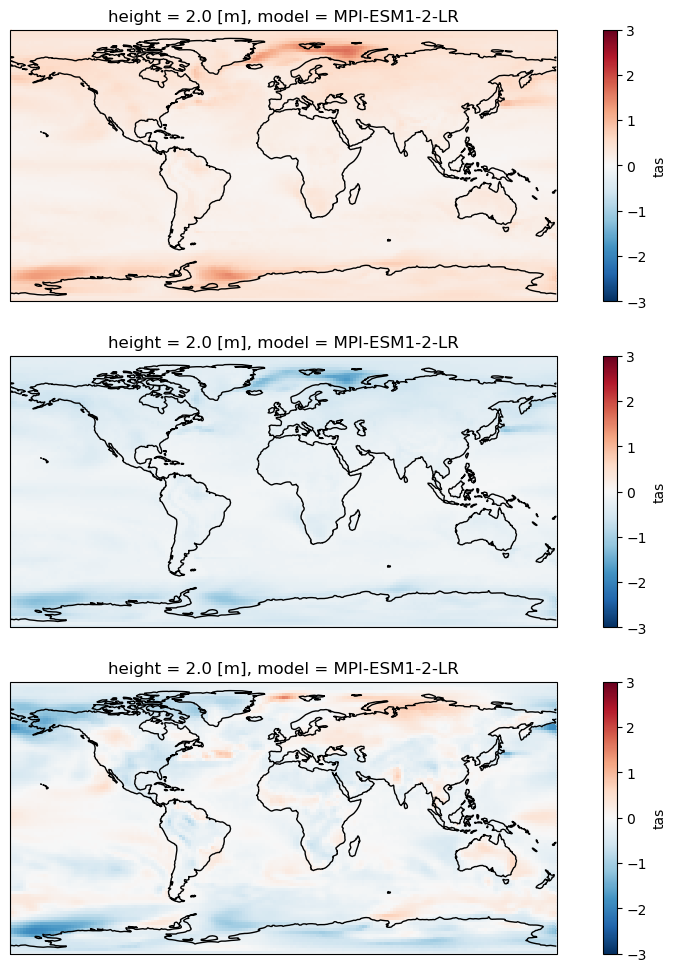

In [53]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
[ax.coastlines() for ax in axes]

kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-3, vmax=3)
upper_bound.plot(ax=axes[0], **kwargs)
lower_bound.plot(ax=axes[1], **kwargs)
a1_ds_local_zec25_ds.plot(ax=axes[2], **kwargs)

In [54]:
warmer_than_pi = xr.where(a1_ds_local_zec25_ds > upper_bound, 1, 0)
cooler_than_pi = xr.where(a1_ds_local_zec25_ds < lower_bound, -1, 0)
pi_comparison = warmer_than_pi + cooler_than_pi
pi_comparison = pi_comparison.compute()

Text(0.5, 1.0, 'Warmer/Cooler the pi')

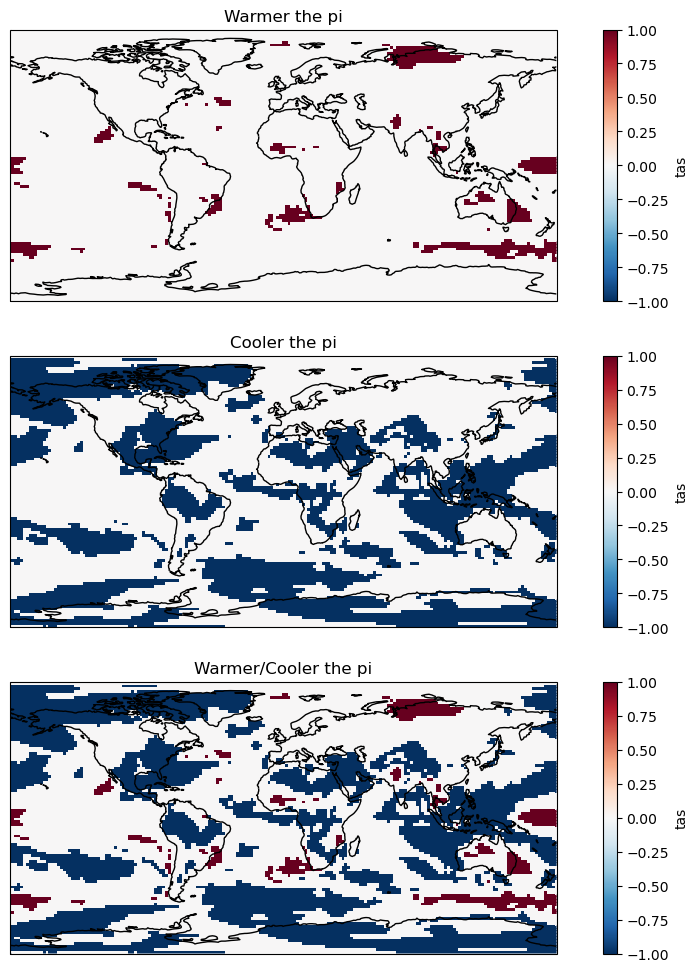

In [55]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()
[ax.coastlines() for ax in axes]

kwargs = dict(transform=ccrs.PlateCarree())
warmer_than_pi.plot(ax=axes[0], vmin=-1, vmax=1, cmap='RdBu_r')
cooler_than_pi.plot(ax=axes[1], vmin=-1, vmax=1, cmap='RdBu_r')
pi_comparison.plot(ax=axes[2], vmin=-1, vmax=1, cmap='RdBu_r')

axes[0].set_title('Warmer the pi')
axes[1].set_title('Cooler the pi')
axes[2].set_title('Warmer/Cooler the pi')

# Global pi-Control Gradients

/g/data/w40/ab2313/images/PhD/top_level/draft_06_zec_global_average_zec_model_drift_esm_picontrol.png


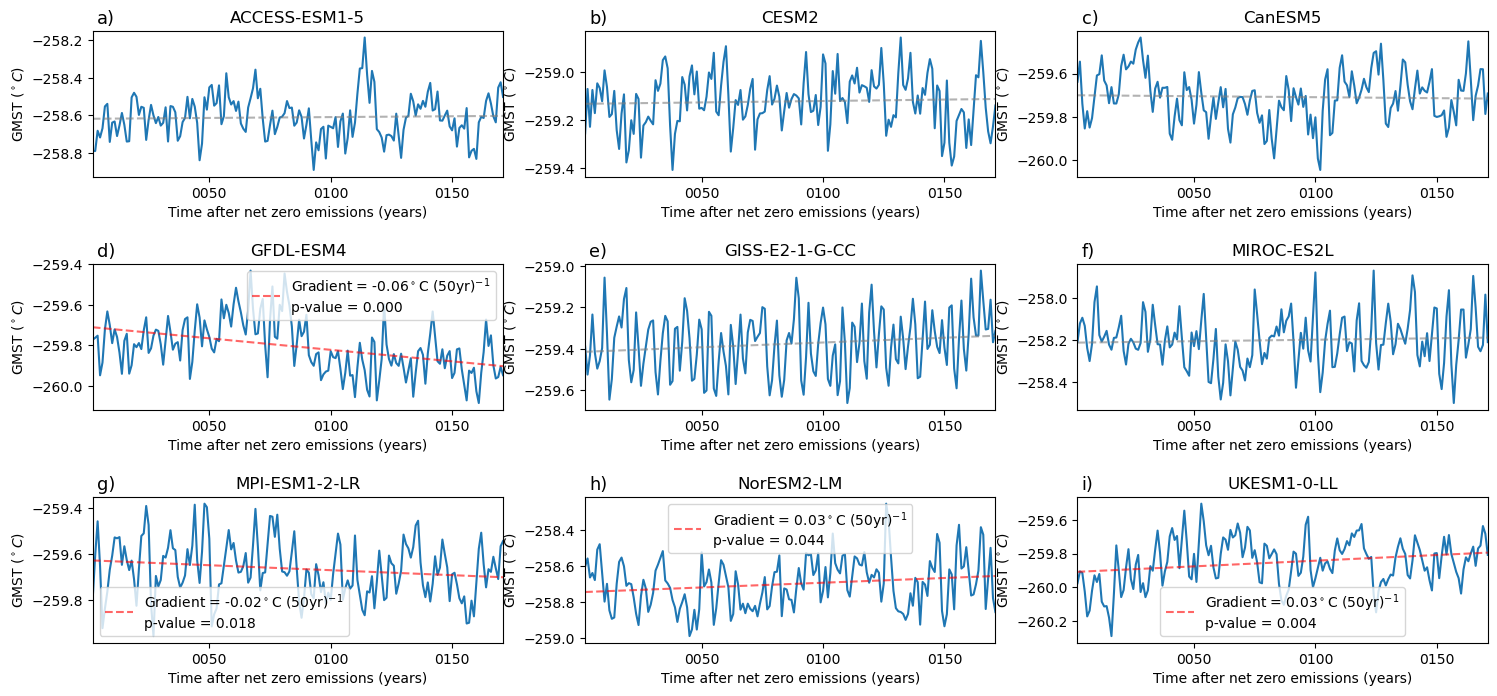

In [56]:
models = esm_picontrol_smean_ds.model.values
time = esm_picontrol_smean_ds.time.values
ncols = 3; nrows = int(np.ceil(len(models)/2))

fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, hspace=0.6)

for num, model in enumerate(models):
    ax = fig.add_subplot(gs[num])
    plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.8)
    esm_picontrol_smean_ds.tas.sel(model=model).plot(ax=ax)
    ax.set_title(model); ax.set_ylabel(r'GMST $(^\circ C)$'); ax.set_xlabel('Time after net zero emissions (years)')
    ax.set_xlim([time[0], time[-1]])
    init_y = esm_picontrol_smean_ds.sel(model=model).tas.values

    x = np.arange(len(init_y))

    grad_yint = np.polyfit(x, init_y, deg=1)

    fitted_line = np.polyval(grad_yint, x)
    mk_val = pymannkendall.original_test(init_y)
    mk_pval = mk_val.p
    if mk_pval < 0.05:
        color = 'red'
        label = f'Gradient = {grad_yint[0]*50:.2f}' + r'$^\circ$C (50yr)$^{-1}$' + f'\np-value = {mk_pval:.3f}'
    else:
        color='grey'
        label=None
    
    ax.plot(time, fitted_line, linestyle='--', alpha=0.6, color=color, label=label)
    if mk_pval < 0.05:
        ax.legend(ncol=1, loc='best')#bbox_to_anchor=(0.6, 1.06))
        
        
save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_global_average_zec_model_drift_esm_picontrol.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

# Local Gradient and p-value

In [57]:
# tds =  esm_picontrol_ds_xrlist.isel(time=slice(0, 100)).single_xarray()

# esm_picontrol_ds_xrlist.squeeze().single_xarray()

# drift_functions.calculate_pvals(tds.squee

# pi_pval_da = drift_functions.calculate_pvals(esm_picontrol_zec_da.isel(time=slice(0, 100)))
# exp_pval_da = drift_functions.calculate_pvals(experiment_zec_da)

In [ ]:
pi_pval_xrlist = esm_picontrol_ds_xrlist.isel(time=slice(0, 100)).squeeze().apply(drift_functions.calculate_pvals)
pi_pval_xrlist

In [ ]:
a1_ds_xrlist.refkeys

In [60]:
a1_pval_xrlist = a1_ds_xrlist.squeeze().apply(drift_functions.calculate_pvals)

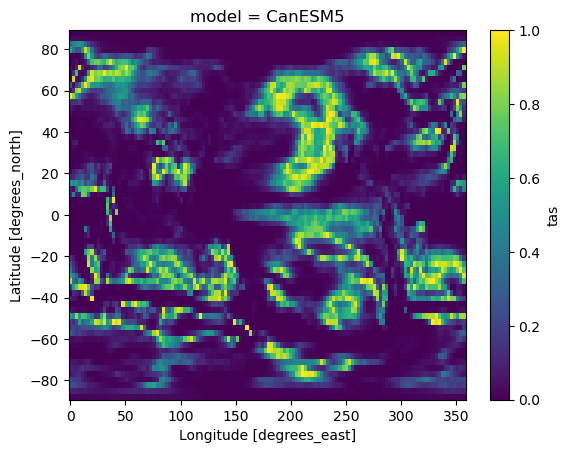

In [61]:
a1_pval_xrlist.single_xarray().plot()

In [62]:
# # Just the p-values that are less tha 0.05
# pi_sig_da = xr.where(pi_pval_da < 0.05, 1, np.nan)
# exp_sig_da = xr.where(exp_pval_da < 0.05, 1, np.nan)

exp_sig_xrlist = a1_pval_xrlist.less_than(0.05, 1, np.nan)
pi_sig_xrlist = pi_pval_xrlist.less_than(0.05, 1, np.nan)

In [63]:
pi_sig_xrlist = pi_sig_xrlist.set_refkeys('model')
exp_sig_xrlist = exp_sig_xrlist.set_refkeys('model')

In [64]:
# Calculating the gradient over the 100 year run length
# gradient_exp_full_da = drift_functions.calculate_trend(experiment_zec_da);
# gradient_pi_full_da = drift_functions.calculate_trend(esm_picontrol_zec_da.isel(time=slice(0, 100)))

gradient_pi_full_xrlist = esm_picontrol_ds_xrlist.isel(time=slice(0, 100)).squeeze().apply(drift_functions.calculate_trend)
gradient_exp_full_xrlist = a1_ds_xrlist.squeeze().apply(drift_functions.calculate_trend).set_refkeys('model')

In [65]:
# Multiplying gradient by 50 to get K per 50 years
gradient_pi_full_xrlist = (gradient_pi_full_xrlist * 50).persist().set_refkeys('model')
gradient_exp_full_xrlist = (gradient_exp_full_xrlist * 50).persist().set_refkeys('model')

In [66]:
# Getting the difference in the gradients
gradient_full_diff_xrlist = gradient_exp_full_xrlist - gradient_pi_full_xrlist
gradient_full_diff_xrlist

Number of da/ds: 9
---------------
CanESM5         ({'lat': 64, 'lon': 128})
MIROC-ES2L      ({'lat': 64, 'lon': 128})
UKESM1-0-LL     ({'lat': 144, 'lon': 192})
MPI-ESM1-2-LR   ({'lat': 96, 'lon': 192})
GISS-E2-1-G-CC  ({'lat': 90, 'lon': 144})
CESM2           ({'lat': 192, 'lon': 288})
NorESM2-LM      ({'lat': 96, 'lon': 144})
GFDL-ESM4       ({'lat': 180, 'lon': 288})
ACCESS-ESM1-5   ({'lat': 145, 'lon': 192})

In [67]:
reload(sn_plotting)

<module 'sn_plotting' from '/home/563/ab2313/Documents/PhD/modules/sn_plotting.py'>

<class 'listXarray.listXarray'>
<class 'listXarray.listXarray'>
<class 'listXarray.listXarray'>
/g/data/w40/ab2313/images/PhD/top_level/draft_06_zec_zec_local_model_drift_esm_picontrol.png


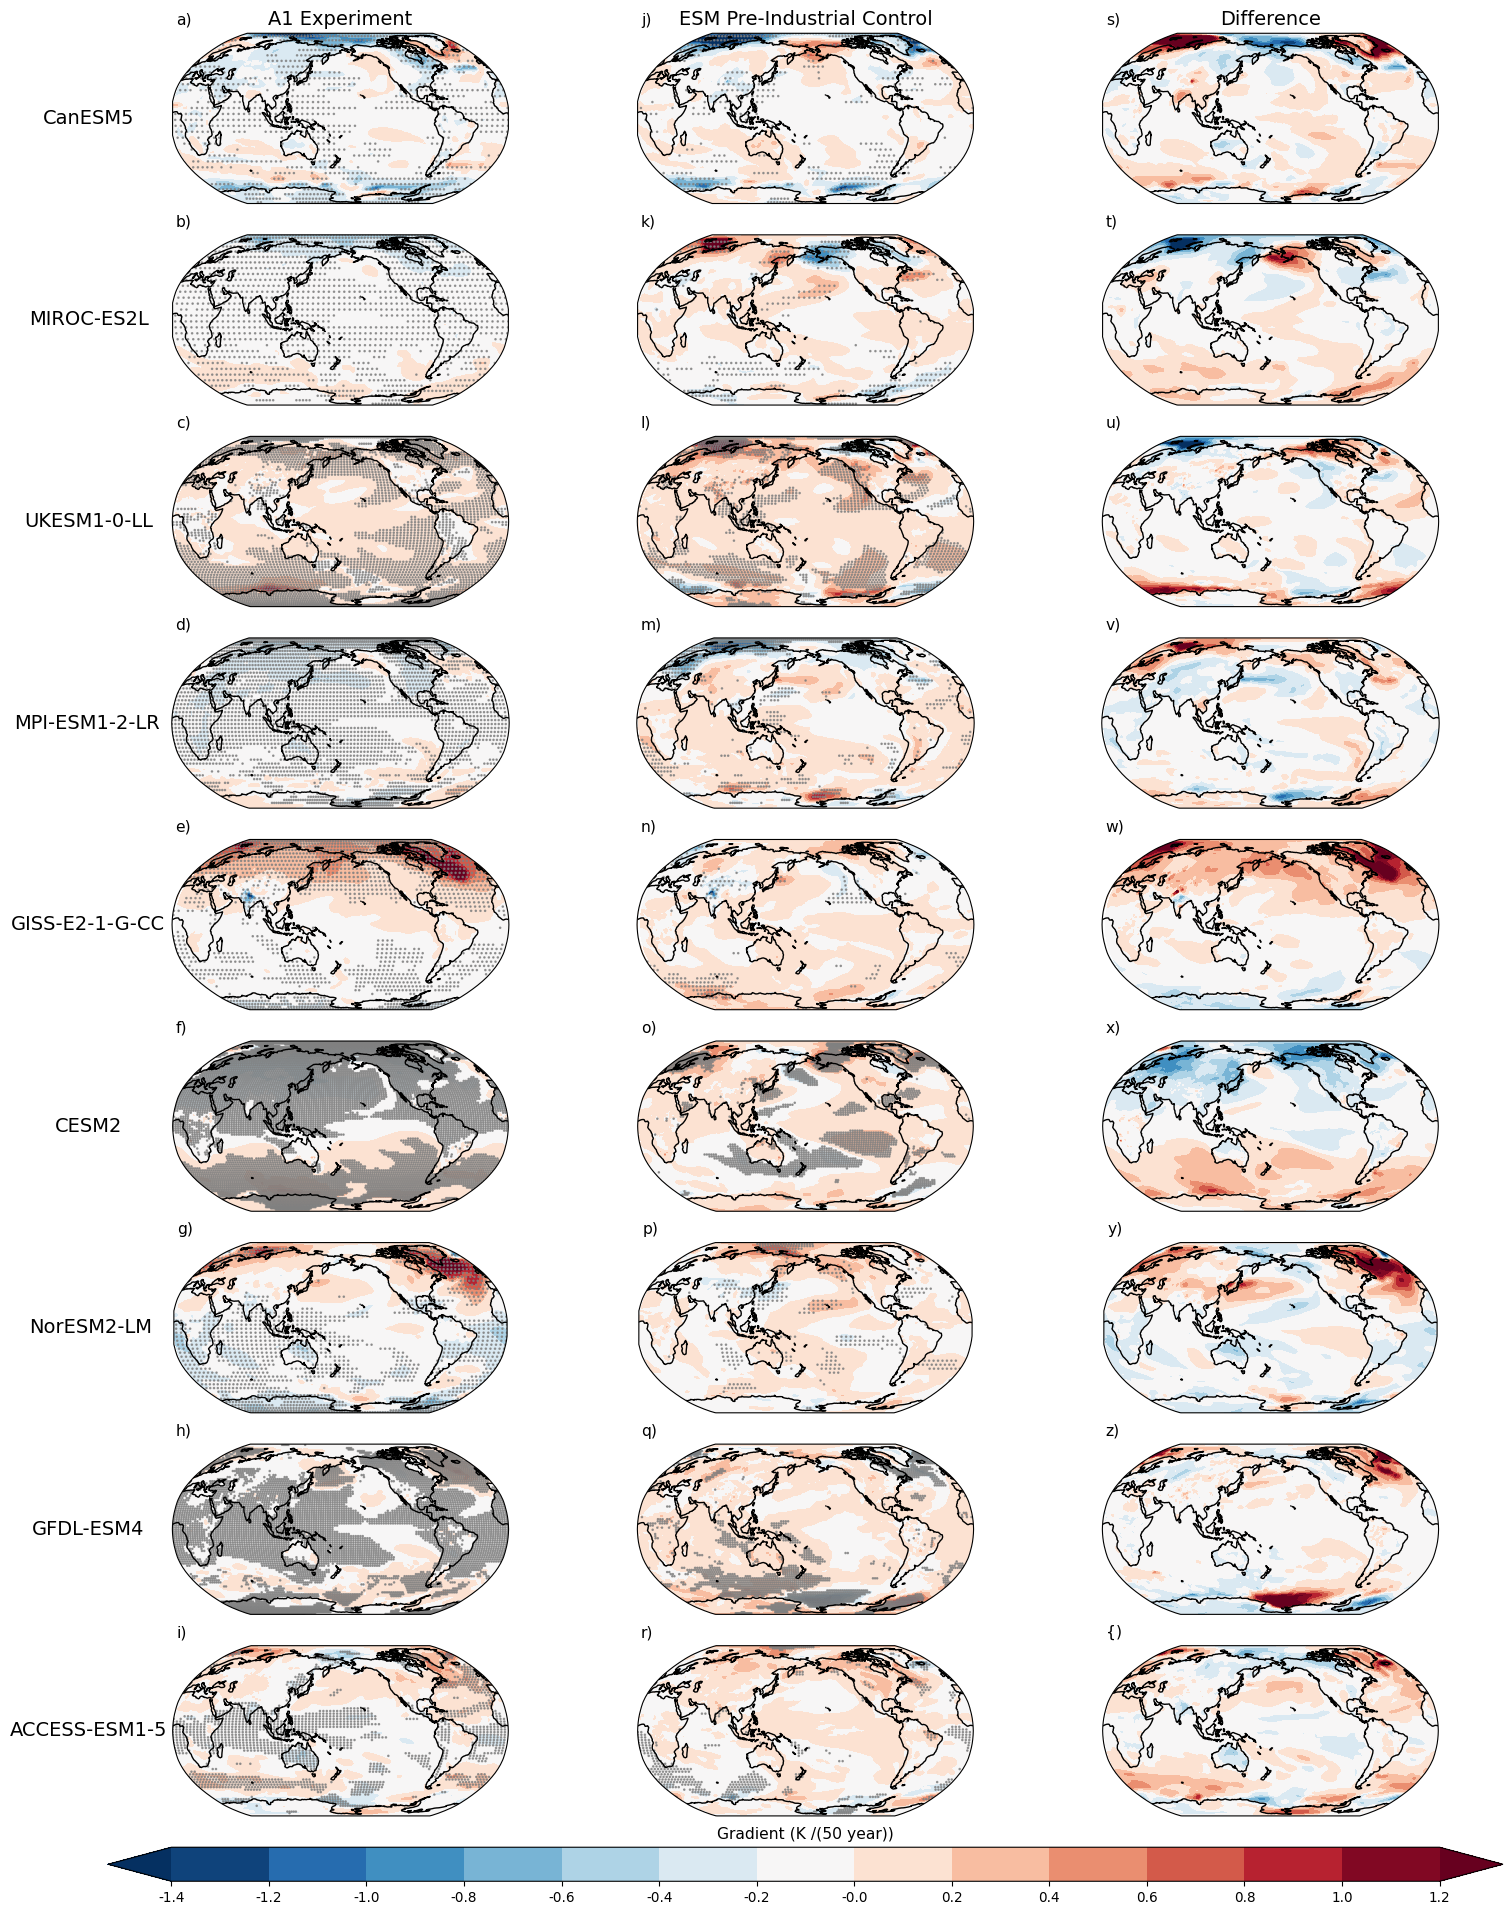

In [68]:
models = gradient_full_diff_xrlist.refkeys
nrows = len(models); ncols = 3
fig = plt.figure(figsize=(6*ncols, 8*ncols))
gs = gridspec.GridSpec(nrows+1, ncols, height_ratios = [1]*nrows +[0.2], hspace=.2, wspace=0)
projection = ccrs.Robinson(central_longitude=int(np.mean(gradient_full_diff_xrlist.single_xarray().lon.values)))


drift_plot_levels = np.arange(-1.4, 1.4, .2)
drift_plot_kwargs = dict(levels=drift_plot_levels, extend='both', cmap='RdBu_r', add_label=False, font_scale=0.7)
vm =40; step=5; levels_mean_stab2 = np.arange(0, vm+step, step)
all_axes = []


fig, gs, axes1 = sn_plotting.map_plot_all_for_coords_3(
    gradient_exp_full_xrlist, dim='model',
    fig=fig, gs=gs, add_colorbar=False, stipling_da=exp_sig_xrlist,
    axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(len(models))],
    **drift_plot_kwargs)

for num, (ax, model) in enumerate(zip(axes1, models)):
    # ax.set_ylabel(model, labelpad=500)
    # sn_plotting.plot_stippled_data(pi_sig_da.sel(model=model), ax) # TODO: This is not working in the `map_plot_all_for_coords_2` function
    if num == 0: ax.set_title('A1 Experiment', fontsize=constants.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
    else: ax.set_title('')
    
y_axis_kwargs = dict(xy=(-.25, 0.5), ha='center', va='center', xycoords='axes fraction', rotation=0,
                     size=constants.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
for model, ax in zip(models, axes1): ax.annotate(model, **y_axis_kwargs)
all_axes.extend(axes1)


#### Pi-control
fig, gs, axes2 = sn_plotting.map_plot_all_for_coords_3(
    gradient_pi_full_xrlist, dim='model',
    fig=fig, gs=gs, add_colorbar=False,stipling_da=pi_sig_xrlist, 
    axes = [fig.add_subplot(gs[i, 1], projection=projection) for i in range(len(models))],
    **drift_plot_kwargs)
for ax in axes2: ax.set_title('')
axes2[0].set_title('ESM Pre-Industrial Control', size=constants.PlotConfig.title_size*drift_plot_kwargs['font_scale'])

all_axes.extend(axes2)

### Diff

fig, gs, axes3 = sn_plotting.map_plot_all_for_coords_3(
    gradient_full_diff_xrlist, dim='model',
     cbar_title="Gradient (K /(50 year))", fig=fig, gs=gs,
    axes = [fig.add_subplot(gs[i, 2], projection=projection) for i in range(len(models))],
    cax = plt.subplot(gs[nrows, :]), 
    **drift_plot_kwargs)
for ax in axes3: ax.set_title('')
axes3[0].set_title('Difference', size=constants.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
all_axes.extend(axes3)

for num, ax in enumerate(all_axes): plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.7)

save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_zec_local_model_drift_esm_picontrol.png')
print(save_name)
# fig.savefig(save_name, dpi=500, bbox_inches='tight')

# Parallel Period Comparison

## Global Average

In [69]:
# esm_picontrol_zec_smean_da
# esm_exp_zec_smean_da

In [70]:
def calculate_anomalies_from_base_period(da:xr.DataArray, base_period:int=20) -> xr.DataArray:
    # The anomalies should be calculated compared to the first 20 years.
    base_period_ds = da.isel(time=slice(None, base_period)).mean(dim='time')
    # Anomalies 
    anomalies_ds = da.isel(time=slice(base_period, None)).rolling(time=20, center=True).mean().dropna(dim='time') - base_period_ds
    return anomalies_ds

In [71]:
picontrol_smean_anomalies_da = calculate_anomalies_from_base_period(esm_picontrol_zec_smean_da)
exp_smean_anomalies_da = calculate_anomalies_from_base_period(esm_exp_zec_smean_da)

NameError: name 'esm_picontrol_zec_smean_da' is not defined

In [ ]:
anomly_smean_difference = exp_smean_anomalies_da - picontrol_smean_anomalies_da

In [ ]:
picontrol_smean_anomalies_da.sel(model=model).plot.hist()

In [ ]:
bins = np.arange(-.5, .5, .02)

In [ ]:
models = picontrol_smean_anomalies_da.model.values
fig = plt.figure(figsize=(15, 8))
ncols = 3
nrows = int(np.ceil(len(models)/ncols))
gs = gridspec.GridSpec(nrows, ncols, hspace=.35)

axes = [fig.add_subplot(gs[i]) for i in range(nrows* ncols)]
for ax, model in zip(axes, models):
    picontrol_smean_anomalies_da.sel(model=model).plot.hist(ax=ax, bins=bins, alpha=.5, label='picontrol');
    exp_smean_anomalies_da.sel(model=model).plot.hist(ax=ax, bins=bins, alpha=.5, label='A1')
    ax.set_title(model)
    ax.legend()